In [70]:
import numpy as np
import pandas as pd
import os
from fnmatch import fnmatch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [71]:
data = pd.read_csv('./data/DFBS_extracted.csv', index_col='Unnamed: 0')
data.head()

,_Glon,_Glat,_RAJ2000,_DEJ2000,Cl,Name,Vmag,z,plate,path,dx,dy
22,120.963506,-22.480532,10.472500,40.354722,Sy1,MARK 957,15.14,0.073,fbs0809_cor,data/images/22__MARK 957.tiff,4310.0,7798.0
23,121.040282,-22.511401,10.567083,40.326667,Sy1,IV Zw 29,16.30,0.102,fbs0809_cor,data/images/23__IV Zw 29.tiff,4140.0,7738.0
37,129.448039,-49.313722,17.220000,13.337222,Sy1,3C 33.0,15.90,0.060,fbs0089_cor,data/images/37__3C 33.0.tiff,2645.0,316.0
48,131.278073,-30.182368,21.380833,32.136389,Sy1,MARK 993,13.96,0.017,fbs0675a_cor,data/images/48__MARK 993.tiff,8208.0,7323.0
52,132.490266,-28.985106,22.849583,33.143889,Sy1,KUG 0128+328,16.50,0.070,fbs0768M_cor,data/images/52__KUG 0128+328.tiff,5245.0,7784.0


In [72]:
# data = data[data['plate'].notna()]

In [73]:
all_tiff_files = []
listOfFiles = os.listdir('./data/images_2/')
pattern = "*.tiff"
for entry in listOfFiles:
    if fnmatch(entry, pattern):
        all_tiff_files.append('./data/images_2/'+entry)

all_tiff_files[0], len(all_tiff_files)

('./data/images_2/1036__RXS J00281+3103.tiff', 364)

In [74]:
# data = data.drop_duplicates(subset=['Name'])

In [75]:
from time import perf_counter

In [76]:
new_index = 0
arr_data = []
t1 = perf_counter()
for index, row in data.iterrows():
    # if index == 0: continue
    glon = row["_Glon"]
    glat = row["_Glat"]
    raj = row["_RAJ2000"]
    dej = row["_DEJ2000"]
    cl = row["Cl"]
    name = row["Name"]
    vmag = row["Vmag"]
    z = row["z"]
    plate = row["plate"]
    dx = row["dx"]
    dy = row["dy"]
    if cl == "C" or cl == "cv" : 
        continue
        
    for i in range(len(all_tiff_files)):
        tiff_index, file_name = all_tiff_files[i].split("/")[-1].split(".tiff")[0].split('__');
        if (name == file_name) and (index == int(tiff_index)):
            arr_data.append([name, cl, all_tiff_files[i]])
            break

len(arr_data), print(perf_counter() - t1)

0.1503668000000289


(356, None)

In [77]:
cl_data = pd.DataFrame(arr_data)
cl_data.head()

,0,1,2
0,MARK 957,Sy1,./data/images_2/22__MARK 957.tiff
1,IV Zw 29,Sy1,./data/images_2/23__IV Zw 29.tiff
2,3C 33.0,Sy1,./data/images_2/37__3C 33.0.tiff
3,MARK 993,Sy1,./data/images_2/48__MARK 993.tiff
4,KUG 0128+328,Sy1,./data/images_2/52__KUG 0128+328.tiff


In [78]:
cl_data[1].value_counts()

M      113
sd      61
PN      61
Mrk     45
Sy1     38
QSO     21
WD      17
Name: 1, dtype: int64

In [79]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cl_data[1])
cl_data[1]=le.transform(cl_data[1])
cl_data.head()

,0,1,2
0,MARK 957,4,./data/images_2/22__MARK 957.tiff
1,IV Zw 29,4,./data/images_2/23__IV Zw 29.tiff
2,3C 33.0,4,./data/images_2/37__3C 33.0.tiff
3,MARK 993,4,./data/images_2/48__MARK 993.tiff
4,KUG 0128+328,4,./data/images_2/52__KUG 0128+328.tiff


In [80]:
cl_data[1].value_counts()

0    113
2     61
6     61
1     45
4     38
3     21
5     17
Name: 1, dtype: int64

In [81]:
X = cl_data.iloc[:, 2]
Y = cl_data.iloc[:, 1]

In [82]:
X = X.values
Y = Y.values

In [83]:
images_list = []
max_width = 0
max_height = 0
ind = 0
for i in range(len(X)):
    im = Image.open(X[i])
    arr = np.array(im)#.flatten()
    
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list.append(arr)

In [84]:
print(max_width, max_height)
max_width, max_height = 20, 140

20 140


In [85]:
for i in range(len(images_list)):
    s = images_list[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list[i] = arr#.flatten()

20 140


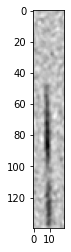

In [86]:
width = max_width
height = max_height
print(width, height)
plt.imshow(images_list[100])
plt.gray()
plt.show()

In [87]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9225545404051689851
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1425070491
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13721973650599192449
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


In [88]:
images_np = np.array(images_list)
file_names_np = np.array(all_tiff_files)

In [89]:
X_train, X_test, Y_train, Y_test = train_test_split(images_np, Y, test_size=0.2, random_state=100, stratify=Y)
Y_train = tf.keras.utils.to_categorical(Y_train, 7)
Y_test = tf.keras.utils.to_categorical(Y_test, 7)

In [90]:
X_train = X_train.reshape(X_train.shape[0], 140, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 140, 20, 1)
input_shape = (140, 20, 1)

In [91]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (284, 140, 20, 1)
284 train samples
72 test samples


In [92]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation

model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), input_shape=input_shape, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 4)))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(7,activation=tf.nn.softmax))

In [93]:
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout, BatchNormalization, Input
from tensorflow.keras import Model
inpu_dim = X_train.shape[1]
h_1 = 2048
h_2 = 1024
h_3 = 512
out_shape = 7

input_vect = Input(shape = (inpu_dim,))
x = BatchNormalization()(input_vect)
x = Dropout(0.5)(x)
x = Dense(h_1, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(h_2, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(h_3, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
encoded = Dense(out_shape, activation='softmax')(x)

encoder = Model(input_vect, encoded)

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 140, 20, 128)      1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 20, 64)        73792     
                                                                 
 activation_2 (Activation)   (None, 46, 20, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 20, 32)       

In [95]:
#image data generator keras
cw = {0:1, 1:1, 2:4, 3:1, 4:4, 5:1, 6:1}
adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)
model.compile(optimizer=adadelta , loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
with tf.device('GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw)

Epoch 1/100
5/5 [==============================] - 3s 403ms/step - loss: 0.7526 - accuracy: 0.1232 - val_loss: 0.4075 - val_accuracy: 0.1667
Epoch 2/100
5/5 [==============================] - 1s 106ms/step - loss: 0.7266 - accuracy: 0.1796 - val_loss: 0.4084 - val_accuracy: 0.1667
Epoch 3/100
5/5 [==============================] - 1s 105ms/step - loss: 0.7058 - accuracy: 0.1725 - val_loss: 0.4127 - val_accuracy: 0.1667
Epoch 4/100
5/5 [==============================] - 1s 103ms/step - loss: 0.7007 - accuracy: 0.1725 - val_loss: 0.4099 - val_accuracy: 0.1667
Epoch 5/100
5/5 [==============================] - 1s 110ms/step - loss: 0.6855 - accuracy: 0.1585 - val_loss: 0.4071 - val_accuracy: 0.1667
Epoch 6/100
5/5 [==============================] - 1s 101ms/step - loss: 0.6756 - accuracy: 0.1655 - val_loss: 0.4050 - val_accuracy: 0.1667
Epoch 7/100
5/5 [==============================] - 1s 105ms/step - loss: 0.6626 - accuracy: 0.1866 - val_loss: 0.4100 - val_accuracy: 0.1667
Epoch 8/100
5

In [97]:
with tf.device('GPU:0'):
    history1 = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw)

Epoch 1/100
5/5 [==============================] - 1s 112ms/step - loss: 0.4574 - accuracy: 0.3838 - val_loss: 0.3080 - val_accuracy: 0.5417
Epoch 2/100
5/5 [==============================] - 0s 100ms/step - loss: 0.4688 - accuracy: 0.3979 - val_loss: 0.3012 - val_accuracy: 0.5417
Epoch 3/100
5/5 [==============================] - 0s 100ms/step - loss: 0.4573 - accuracy: 0.4120 - val_loss: 0.3383 - val_accuracy: 0.2917
Epoch 4/100
5/5 [==============================] - 1s 102ms/step - loss: 0.4635 - accuracy: 0.3486 - val_loss: 0.3105 - val_accuracy: 0.5139
Epoch 5/100
5/5 [==============================] - 1s 105ms/step - loss: 0.4630 - accuracy: 0.3697 - val_loss: 0.3045 - val_accuracy: 0.4861
Epoch 6/100
5/5 [==============================] - 1s 108ms/step - loss: 0.4517 - accuracy: 0.4296 - val_loss: 0.3258 - val_accuracy: 0.3194
Epoch 7/100
5/5 [==============================] - 1s 101ms/step - loss: 0.4537 - accuracy: 0.3979 - val_loss: 0.3204 - val_accuracy: 0.3194
Epoch 8/100
5

In [98]:
with tf.device('GPU:0'):
    history2 = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw)

Epoch 1/100
5/5 [==============================] - 2s 365ms/step - loss: 0.3941 - accuracy: 0.5176 - val_loss: 0.2697 - val_accuracy: 0.6250
Epoch 2/100
5/5 [==============================] - 1s 106ms/step - loss: 0.3920 - accuracy: 0.5669 - val_loss: 0.2814 - val_accuracy: 0.5694
Epoch 3/100
5/5 [==============================] - 0s 100ms/step - loss: 0.3836 - accuracy: 0.5176 - val_loss: 0.2767 - val_accuracy: 0.5417
Epoch 4/100
5/5 [==============================] - 1s 102ms/step - loss: 0.3861 - accuracy: 0.5599 - val_loss: 0.2628 - val_accuracy: 0.5833
Epoch 5/100
5/5 [==============================] - 1s 104ms/step - loss: 0.4004 - accuracy: 0.5563 - val_loss: 0.2853 - val_accuracy: 0.5833
Epoch 6/100
5/5 [==============================] - 0s 100ms/step - loss: 0.3976 - accuracy: 0.5176 - val_loss: 0.2991 - val_accuracy: 0.3889
Epoch 7/100
5/5 [==============================] - 1s 104ms/step - loss: 0.3930 - accuracy: 0.5070 - val_loss: 0.3018 - val_accuracy: 0.5139
Epoch 8/100
5

In [101]:
with tf.device('GPU:0'):
    history3 = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw)

Epoch 1/100
5/5 [==============================] - 1s 119ms/step - loss: 0.3235 - accuracy: 0.6197 - val_loss: 0.2604 - val_accuracy: 0.5833
Epoch 2/100
5/5 [==============================] - 1s 118ms/step - loss: 0.3223 - accuracy: 0.6162 - val_loss: 0.2479 - val_accuracy: 0.5972
Epoch 3/100
5/5 [==============================] - 1s 121ms/step - loss: 0.2996 - accuracy: 0.6549 - val_loss: 0.2529 - val_accuracy: 0.6250
Epoch 4/100
5/5 [==============================] - 1s 106ms/step - loss: 0.3191 - accuracy: 0.6268 - val_loss: 0.2499 - val_accuracy: 0.5694
Epoch 5/100
5/5 [==============================] - 1s 104ms/step - loss: 0.3293 - accuracy: 0.6197 - val_loss: 0.2640 - val_accuracy: 0.5972
Epoch 6/100
5/5 [==============================] - 1s 103ms/step - loss: 0.3003 - accuracy: 0.6373 - val_loss: 0.2570 - val_accuracy: 0.6389
Epoch 7/100
5/5 [==============================] - 1s 142ms/step - loss: 0.3135 - accuracy: 0.6408 - val_loss: 0.2523 - val_accuracy: 0.5694
Epoch 8/100
5

In [102]:
accuracy = np.concatenate([history.history['accuracy'],history1.history['accuracy'], history2.history['accuracy'], history3.history['accuracy']])
val_accuracy = np.concatenate([history.history['val_accuracy'],history1.history['val_accuracy'], history2.history['val_accuracy'], history3.history['val_accuracy']])
loss = np.concatenate([history.history['loss'],history1.history['loss'], history2.history['loss'], history3.history['loss']])
val_loss = np.concatenate([history.history['val_loss'],history1.history['val_loss'], history2.history['val_loss'], history3.history['val_loss']])

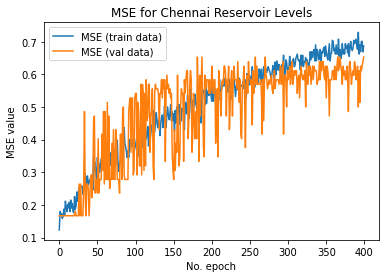

In [103]:
plt.plot(accuracy, label='MSE (train data)')
plt.plot(val_accuracy, label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

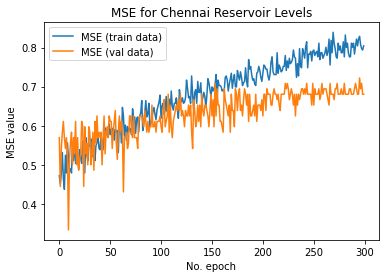

In [68]:
plt.plot(accuracy, label='MSE (train data)')
plt.plot(val_accuracy, label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

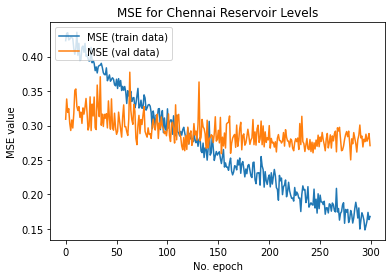

In [69]:
plt.plot(loss, label='MSE (train data)')
plt.plot(val_loss, label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

[0.4720279574394226,
 0.45104894042015076,
 0.47902098298072815,
 0.5314685106277466,
 0.46503496170043945,
 0.43706294894218445,
 0.5244755148887634,
 0.47902098298072815,
 0.5559440851211548,
 0.5174825191497803,
 0.4860139787197113,
 0.4895104765892029,
 0.47902098298072815,
 0.5559440851211548,
 0.5104895234107971,
 0.5699300765991211,
 0.503496527671814,
 0.5174825191497803,
 0.5174825191497803,
 0.4895104765892029,
 0.5384615659713745,
 0.5174825191497803,
 0.503496527671814,
 0.559440553188324,
 0.5454545617103577,
 0.47902098298072815,
 0.5699300765991211,
 0.5279720425605774,
 0.5104895234107971,
 0.5489510297775269,
 0.5489510297775269,
 0.5664335489273071,
 0.5209790468215942,
 0.5209790468215942,
 0.5244755148887634,
 0.5104895234107971,
 0.5489510297775269,
 0.5559440851211548,
 0.5769230723381042,
 0.5419580340385437,
 0.5384615659713745,
 0.5699300765991211,
 0.5629370808601379,
 0.5384615659713745,
 0.5804196000099182,
 0.5944055914878845,
 0.5839160680770874,
 0.576923